# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import sys
import json
import re
import glob

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import gc
from sklearn.preprocessing import LabelBinarizer

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

/home/pqlza/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-17 18:35:52.323829: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 18:35:52.359466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-17 18:35:53.491603: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 18:35:53.495524: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 18:35:53.495653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = 500
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-04-17 18:35:53.505395: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 18:35:53.505536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 18:35:53.505599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-04-17 18:35:54.675856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


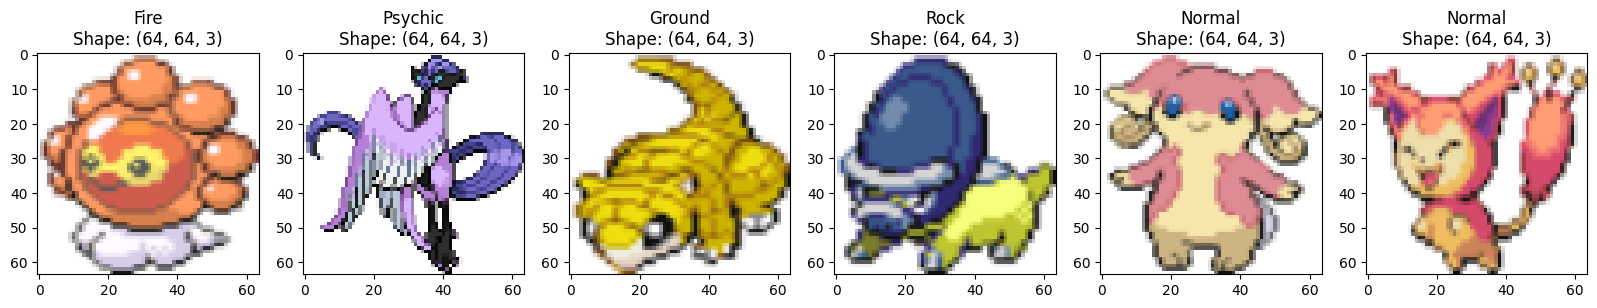

2024-04-17 18:35:55.222427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 64, 64, 3)
(32, 18)


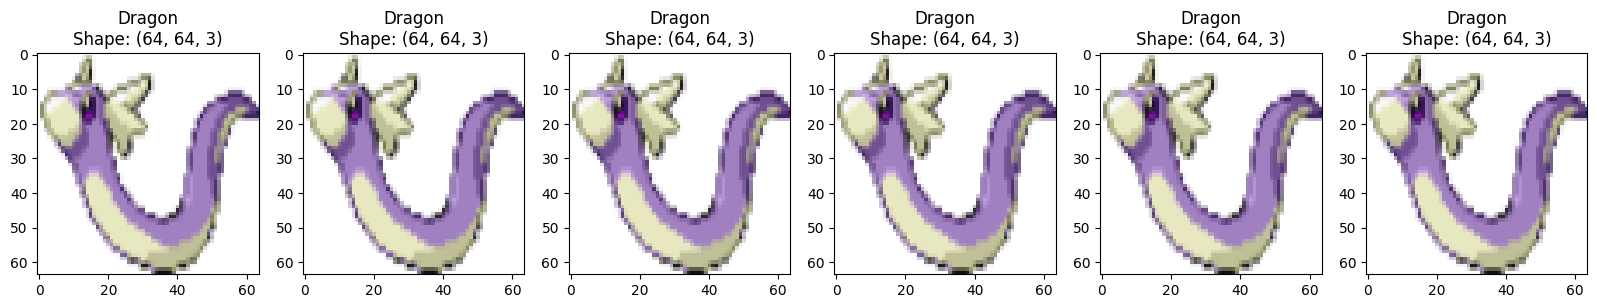

2024-04-17 18:36:28.744430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-17 18:36:28.745862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(256).batch(BATCH_SIZE)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    visualize.plot_images_batch(dataset_tf=dataset_example)

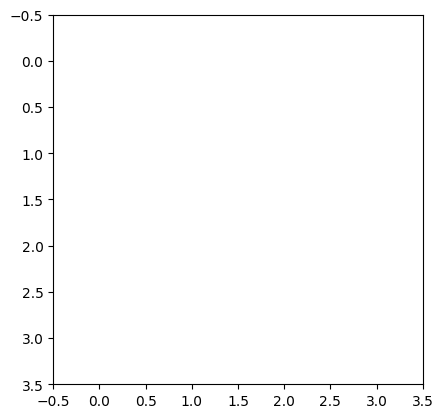

In [37]:
# get the image and the label
for img, label in dataset_example.take(1):
    img_example = img[0]
    label_example = label[0]
    break

# get the coordinates of the bottom right corner of the pokemon
x = 60
y = 60
w = 50
h = 50

# Slice the tensor to get the pixel values within the background area
img_white_area = img_example[y : y + h, x : x + w, :]

plt.imshow(img_white_area)

In [38]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

Epoch 1/100


2024-04-17 18:36:34.566602: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-04-17 18:36:36.565377: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - loss: 1.2166
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - loss: 0.9072
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 0.8238
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.8460

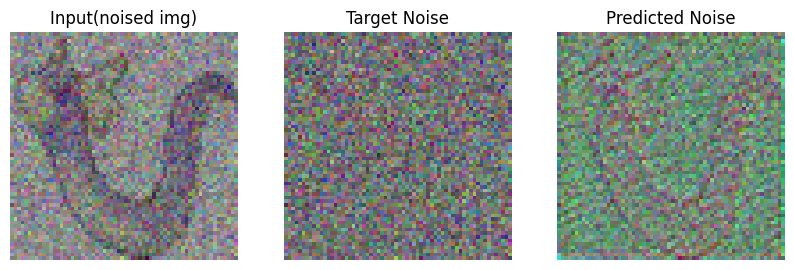

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.010709523, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6360659, shape=(), dtype=float32)


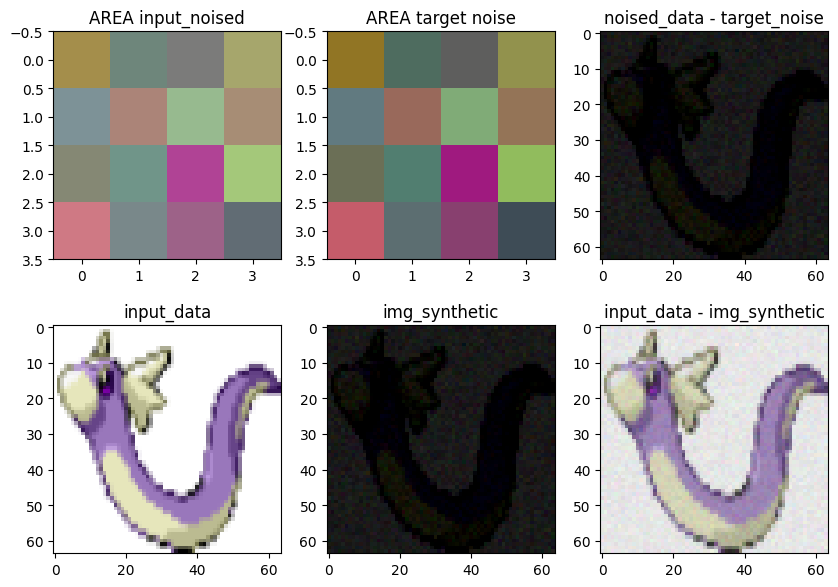

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - loss: 0.7520
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - loss: 0.6847
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.5696
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.4482
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.5185

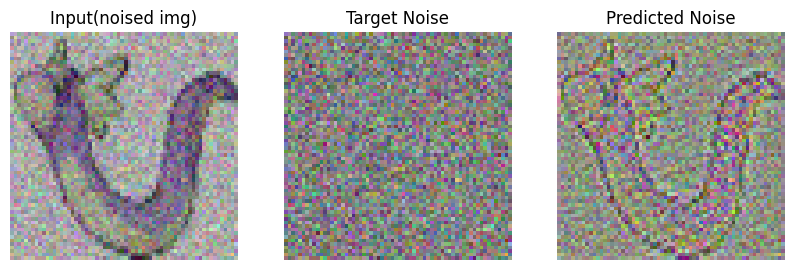

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.025868284, shape=(), dtype=float32)
MSE:  tf.Tensor(0.5866571, shape=(), dtype=float32)


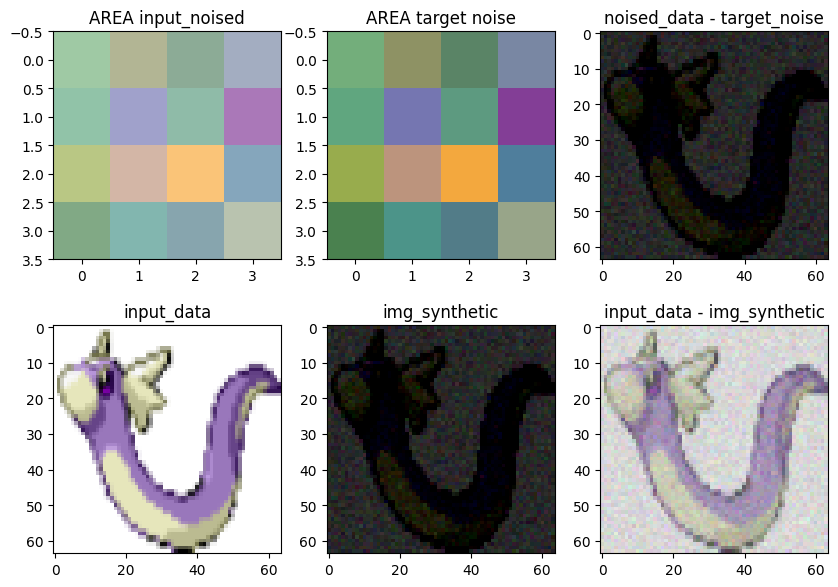

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - loss: 0.4609
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.3777
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - loss: 0.2983
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - loss: 0.3304
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.3227

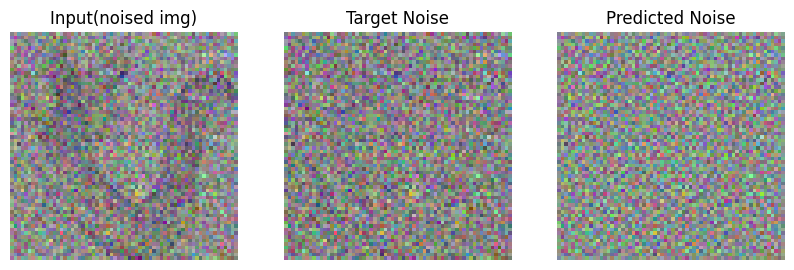

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0014181017, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7178147, shape=(), dtype=float32)


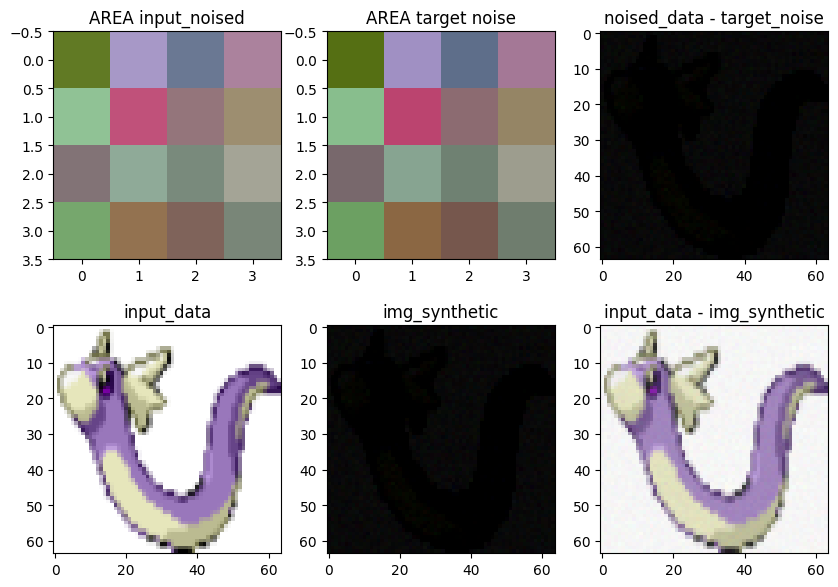

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - loss: 0.2869
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - loss: 0.2307
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - loss: 0.1701
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - loss: 0.1241
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.1014

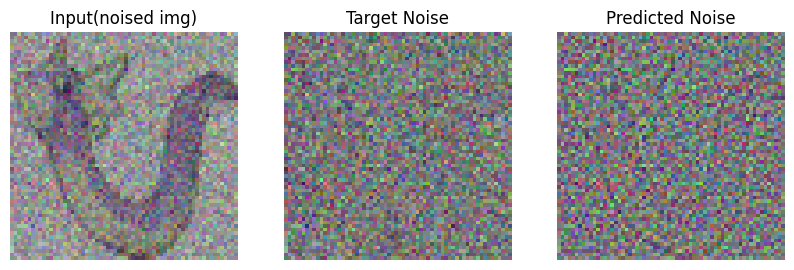

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.013172962, shape=(), dtype=float32)
MSE:  tf.Tensor(0.62004703, shape=(), dtype=float32)


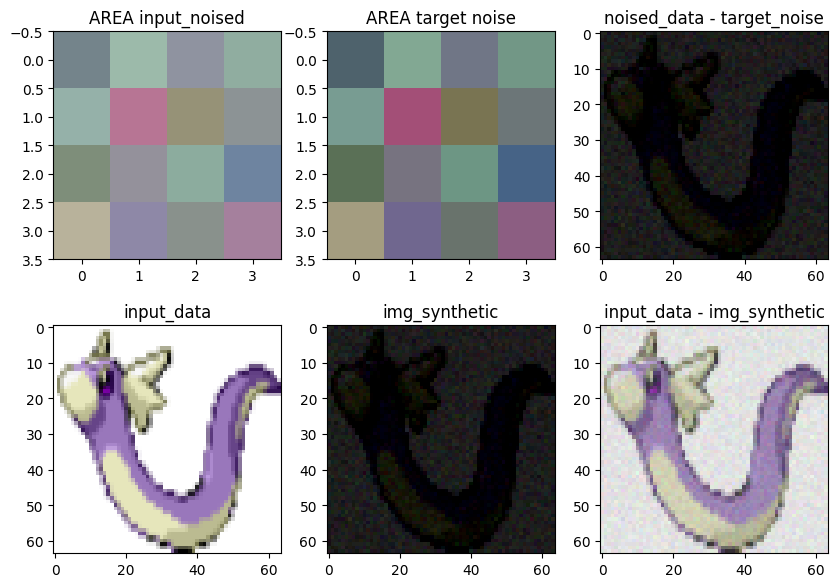

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - loss: 0.0901
Epoch 17/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.1733
Epoch 18/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - loss: 0.1763
Epoch 19/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - loss: 0.0946
Epoch 20/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - loss: 0.1195

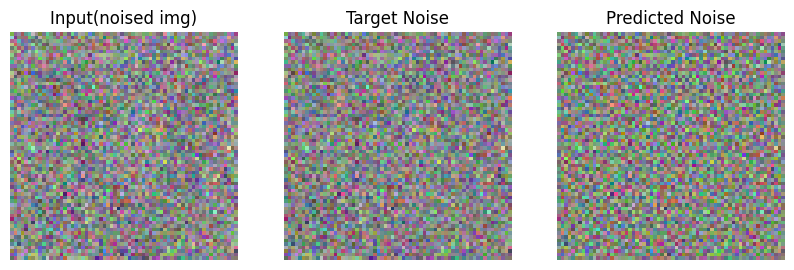

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.00047257275, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7216375, shape=(), dtype=float32)


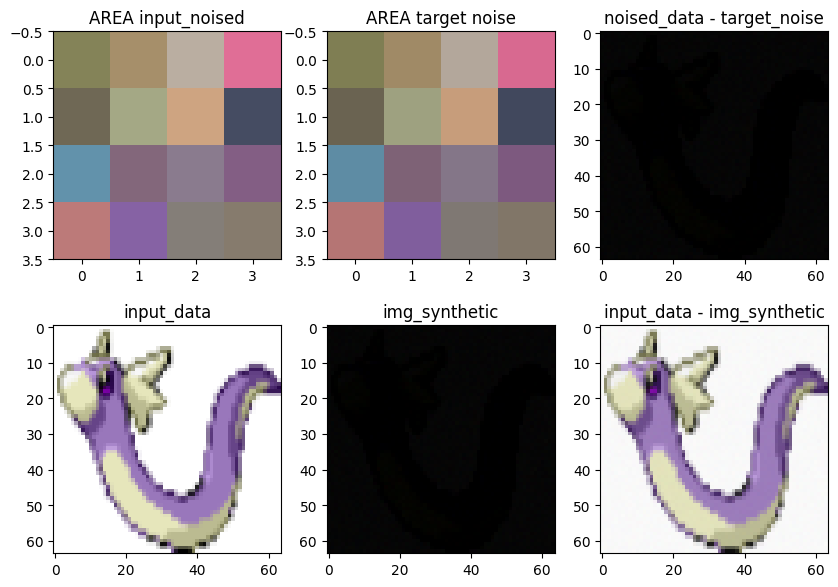

Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:22<00:00, 22.05it/s]


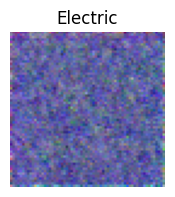

8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - loss: 0.1063  
Epoch 21/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.0987
Epoch 22/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.2222
Epoch 23/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - loss: 0.1959
Epoch 24/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.1138

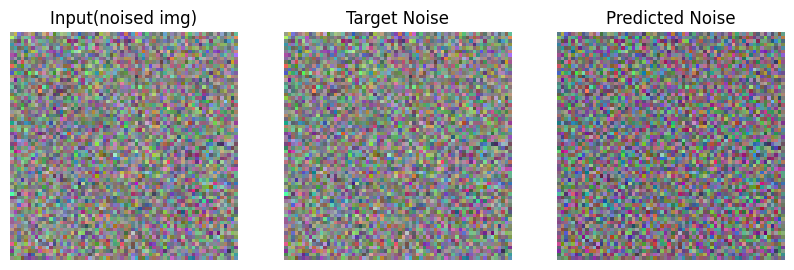

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(8.586645e-05, shape=(), dtype=float32)
MSE:  tf.Tensor(0.73578495, shape=(), dtype=float32)


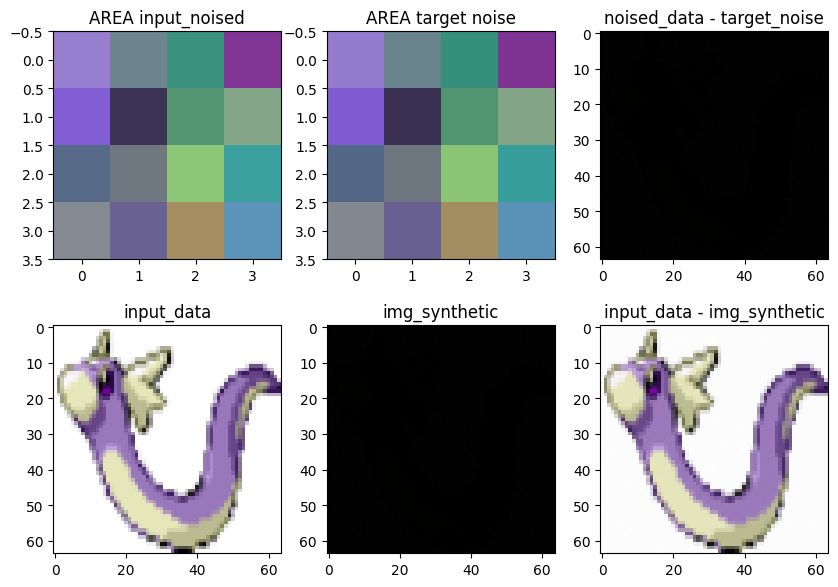

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - loss: 0.1012
Epoch 25/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - loss: 0.1096
Epoch 26/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - loss: 0.0869
Epoch 27/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - loss: 0.0757
Epoch 28/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1744

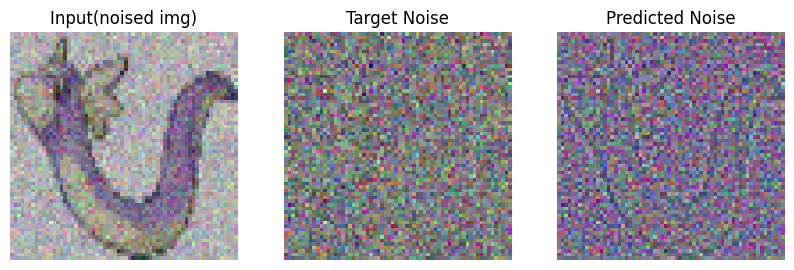

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.04227996, shape=(), dtype=float32)
MSE:  tf.Tensor(0.51982105, shape=(), dtype=float32)


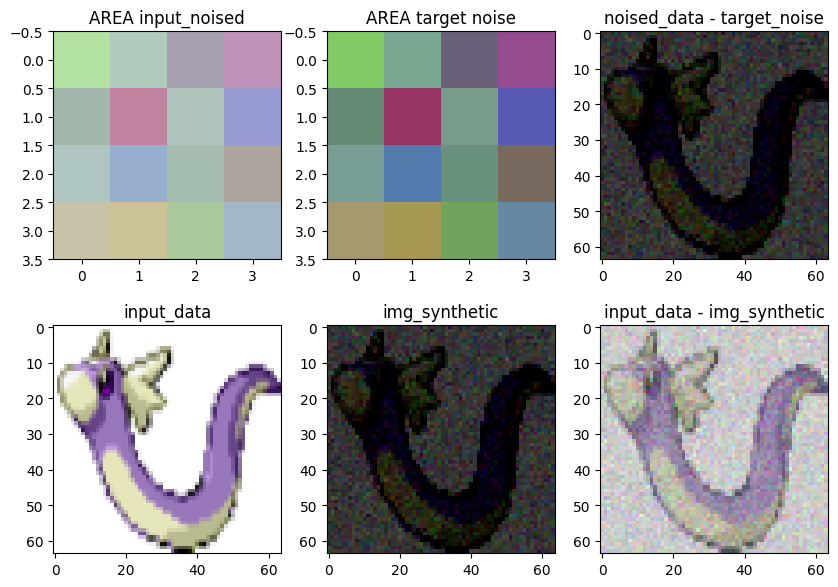

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - loss: 0.1550
Epoch 29/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - loss: 0.1230
Epoch 30/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - loss: 0.0991
Epoch 31/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - loss: 0.3387
Epoch 32/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.2368

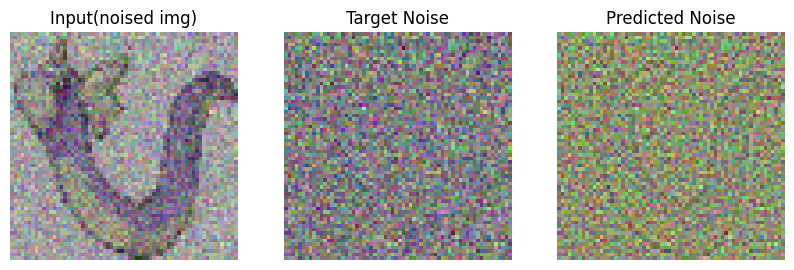

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.01967482, shape=(), dtype=float32)
MSE:  tf.Tensor(0.610153, shape=(), dtype=float32)


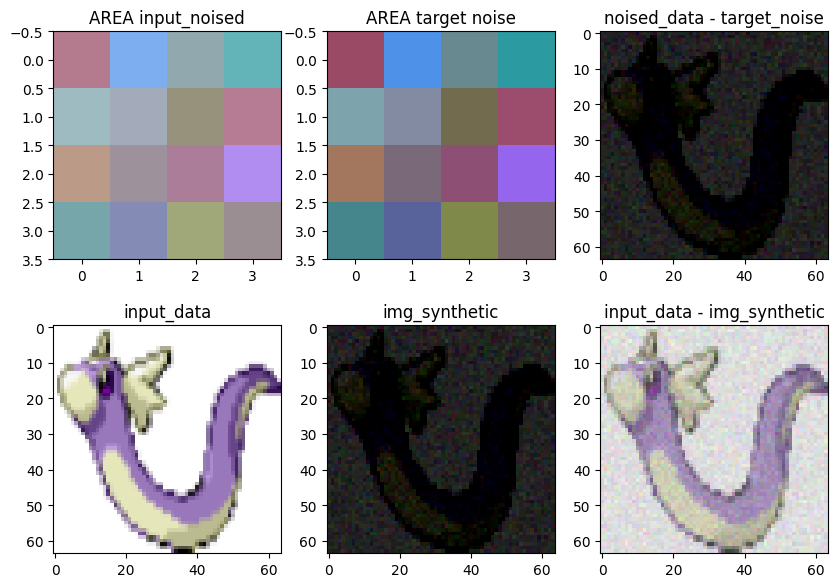

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - loss: 0.2105
Epoch 33/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - loss: 0.1858
Epoch 34/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - loss: 0.1029
Epoch 35/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - loss: 0.1541
Epoch 36/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.1362

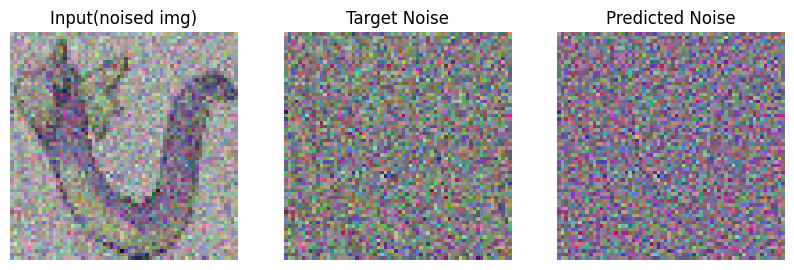

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.021277012, shape=(), dtype=float32)
MSE:  tf.Tensor(0.5979543, shape=(), dtype=float32)


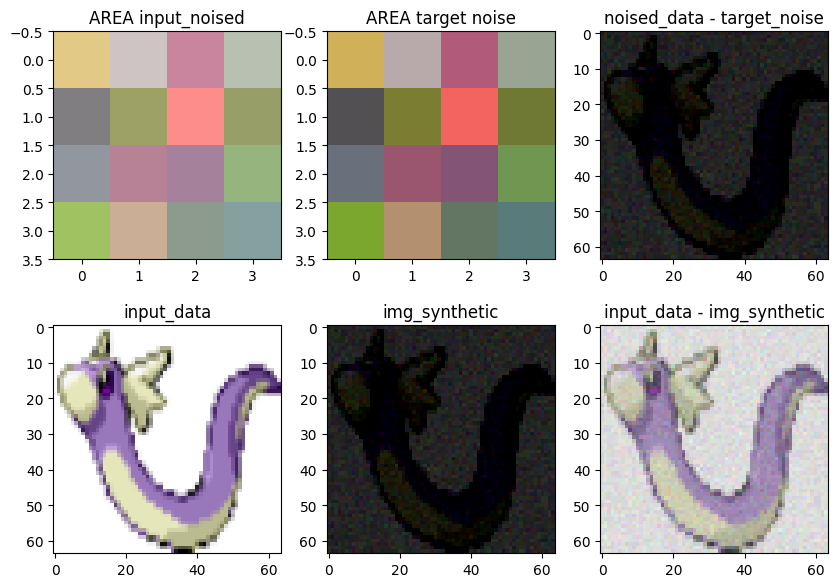

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - loss: 0.1211
Epoch 37/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 0.1602
Epoch 38/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.1890
Epoch 39/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - loss: 0.0752
Epoch 40/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.1377

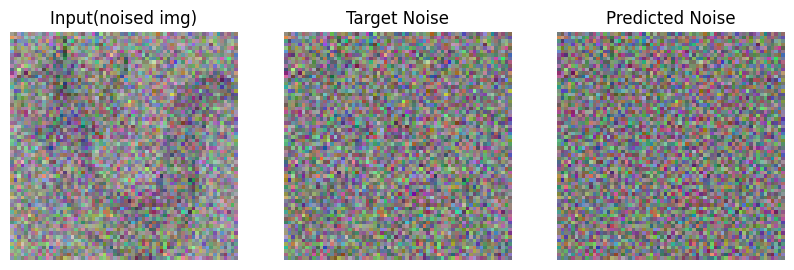

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.005016427, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6694637, shape=(), dtype=float32)


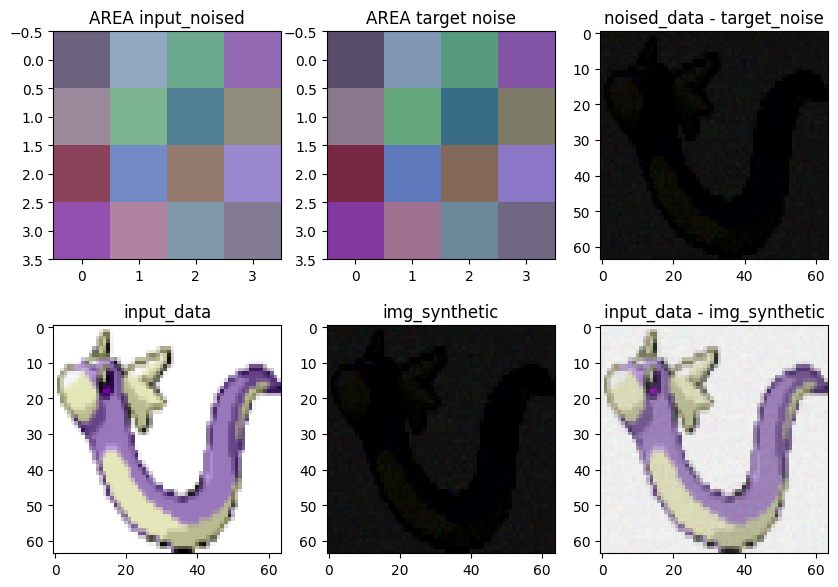

Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:20<00:00, 24.34it/s]


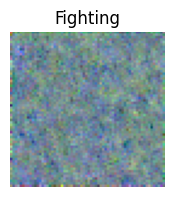

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.1224  
Epoch 41/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.0757
Epoch 42/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - loss: 0.0673
Epoch 43/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - loss: 0.0657
Epoch 44/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.1225

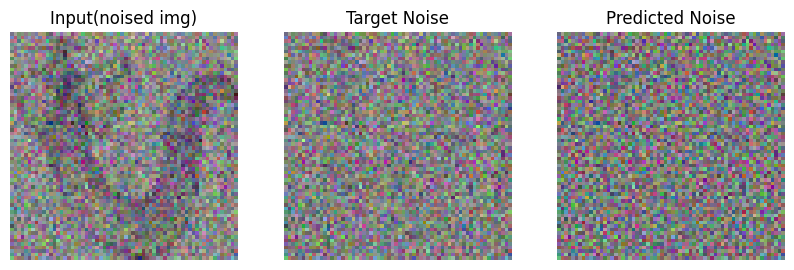

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0010742458, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7342191, shape=(), dtype=float32)


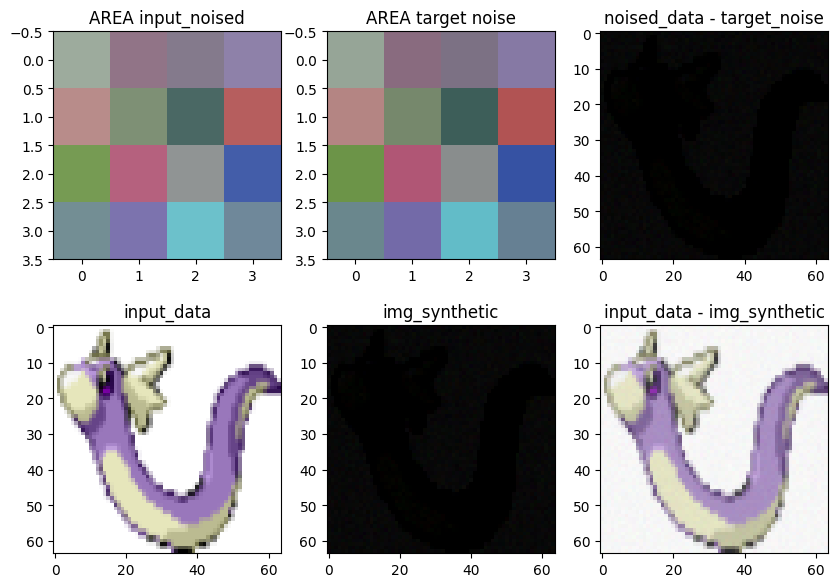

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - loss: 0.1089
Epoch 45/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - loss: 0.0961
Epoch 46/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 0.0701
Epoch 47/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - loss: 0.1893
Epoch 48/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.2079

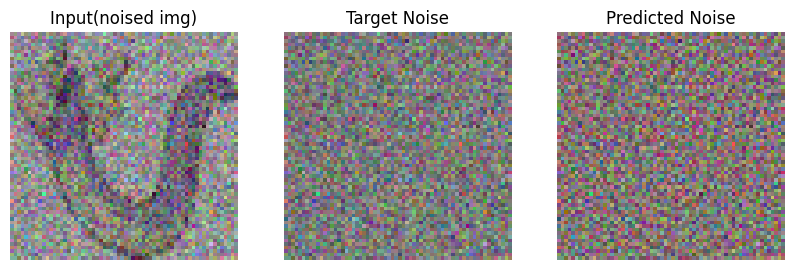

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.008755176, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6534606, shape=(), dtype=float32)


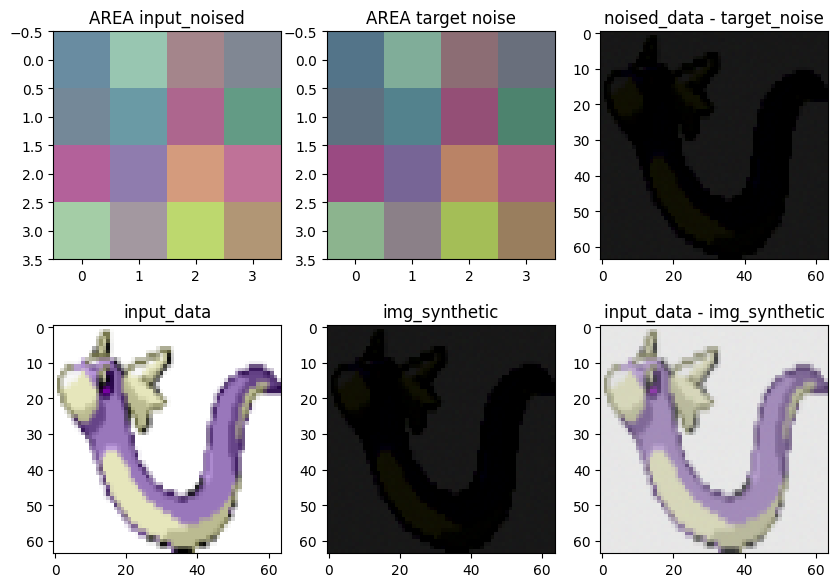

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - loss: 0.1848
Epoch 49/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - loss: 0.0623
Epoch 50/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.0645
Epoch 51/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - loss: 0.2957
Epoch 52/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.2711

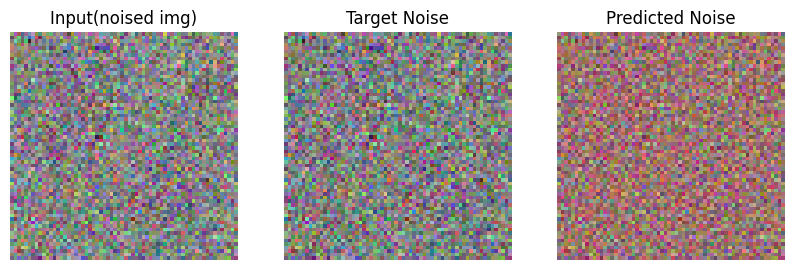

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.00053297903, shape=(), dtype=float32)
MSE:  tf.Tensor(0.71787626, shape=(), dtype=float32)


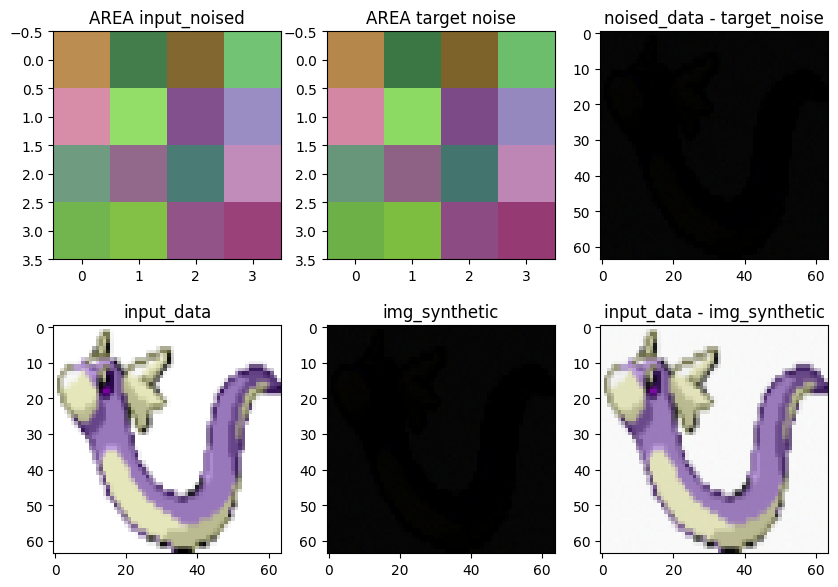

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - loss: 0.2410
Epoch 53/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - loss: 0.1550
Epoch 54/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - loss: 0.1293
Epoch 55/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - loss: 0.1110
Epoch 56/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.0834

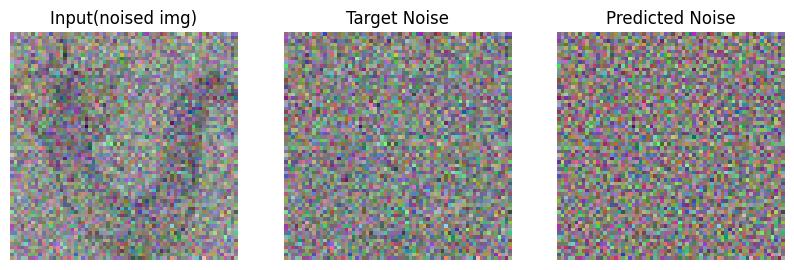

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.002542682, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6971993, shape=(), dtype=float32)


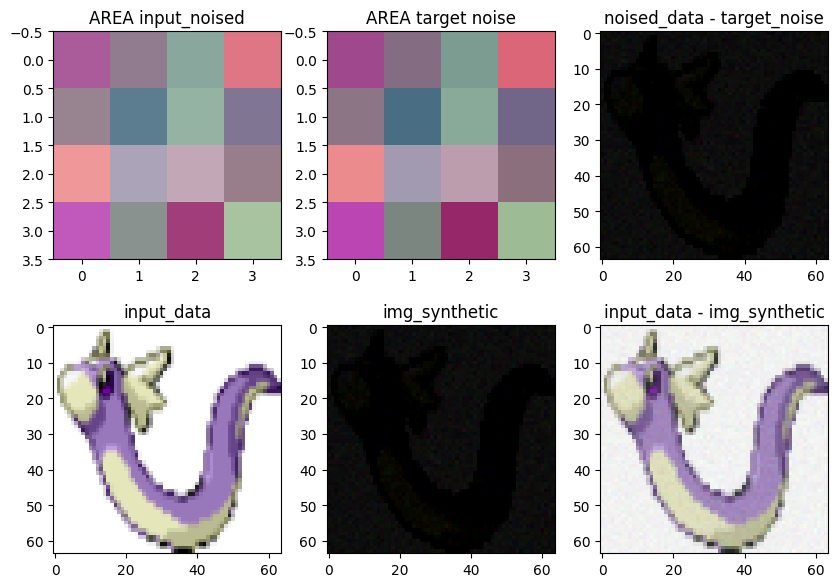

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - loss: 0.0741
Epoch 57/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - loss: 0.0774
Epoch 58/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 0.3292
Epoch 59/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 0.1757
Epoch 60/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.2113

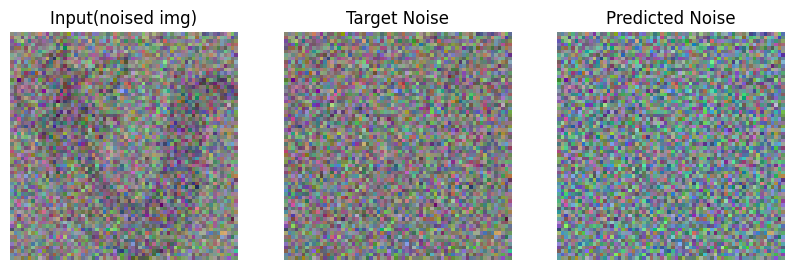

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.00085457927, shape=(), dtype=float32)
MSE:  tf.Tensor(0.72856075, shape=(), dtype=float32)


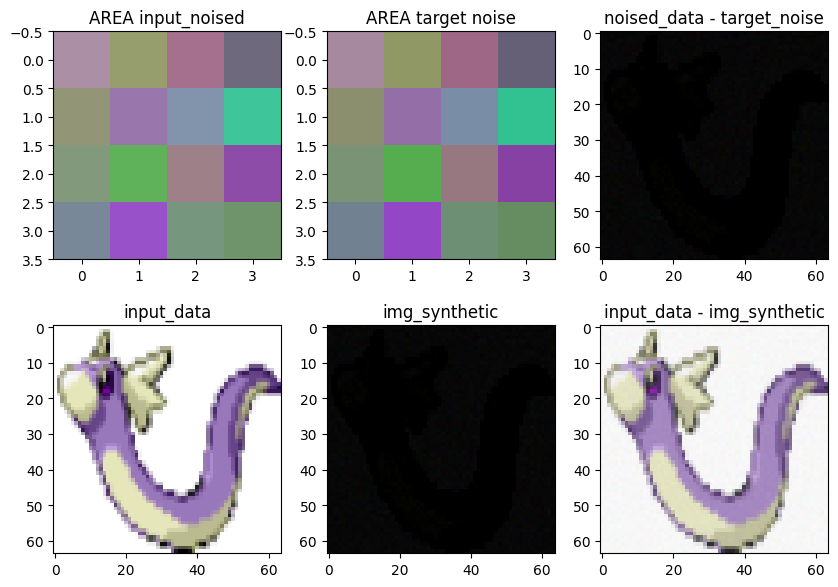

Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:20<00:00, 24.59it/s]


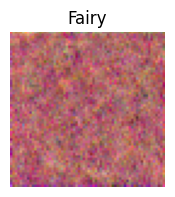

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.1878  
Epoch 61/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - loss: 0.0846
Epoch 62/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.2145
Epoch 63/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.0697
Epoch 64/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.0790

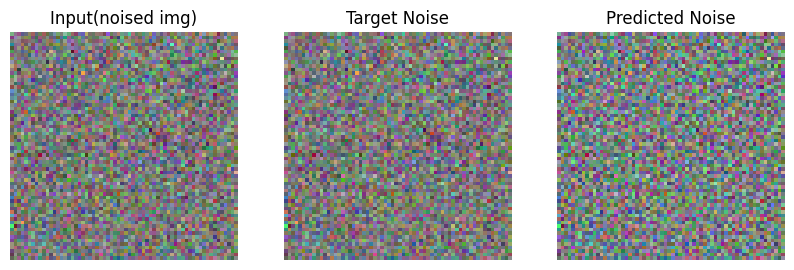

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(1.2073675e-15, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7467763, shape=(), dtype=float32)


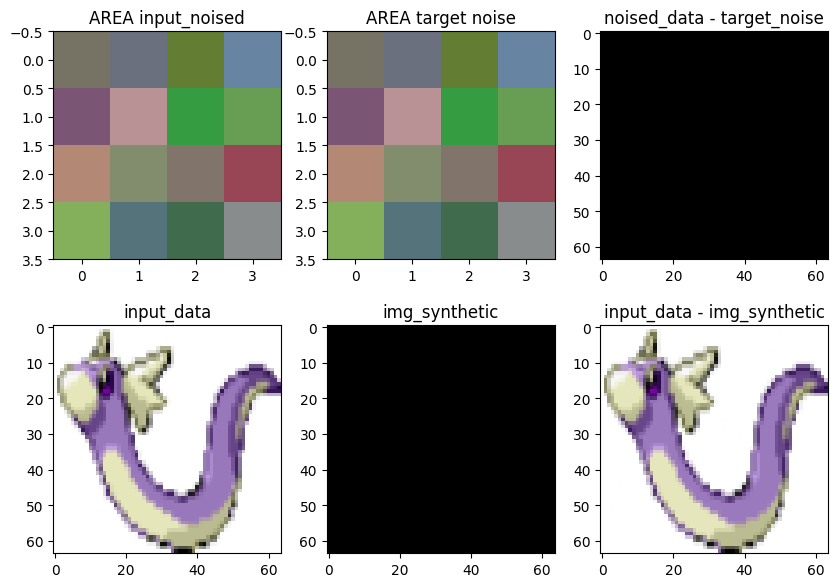

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - loss: 0.0702
Epoch 65/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - loss: 0.0751
Epoch 66/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.0835
Epoch 67/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 0.0575
Epoch 68/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.0854

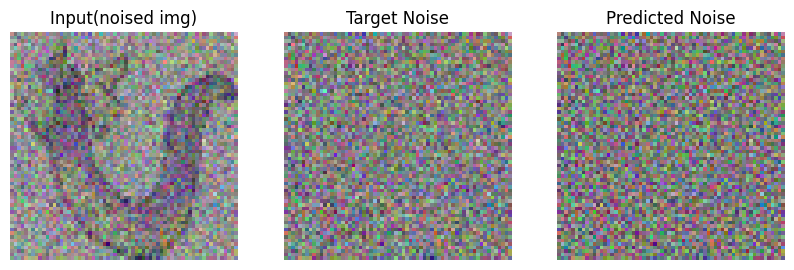

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0058992654, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6807189, shape=(), dtype=float32)


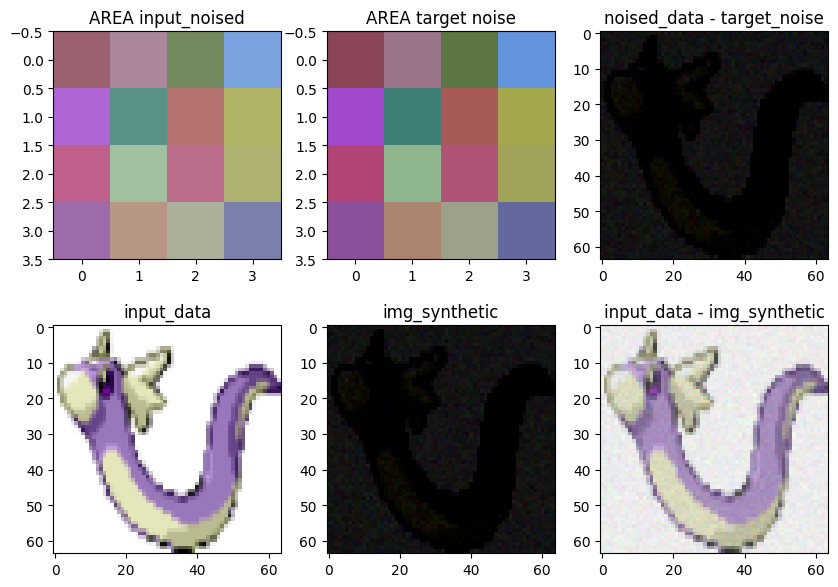

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - loss: 0.0759
Epoch 69/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.1246
Epoch 70/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.1842
Epoch 71/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.0643
Epoch 72/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0583

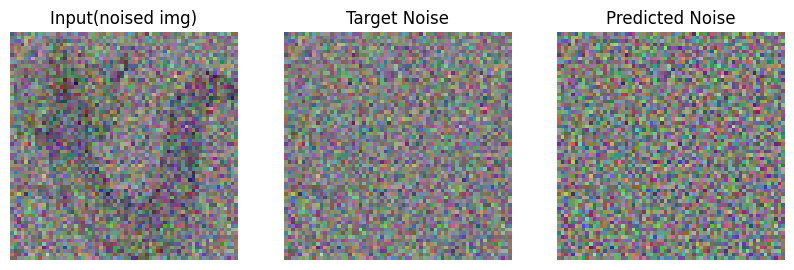

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(8.819101e-05, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7667015, shape=(), dtype=float32)


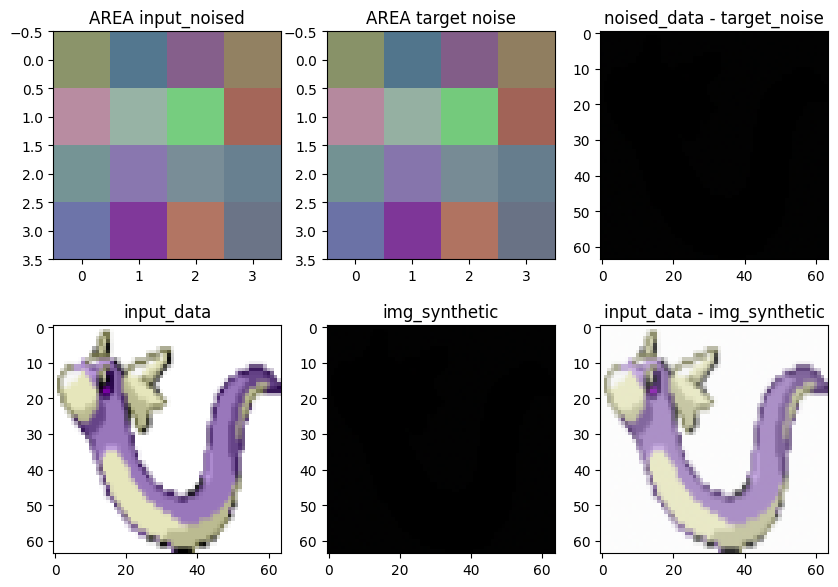

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - loss: 0.0519
Epoch 73/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - loss: 0.1642
Epoch 74/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 0.1002
Epoch 75/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - loss: 0.0583
Epoch 76/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.1079

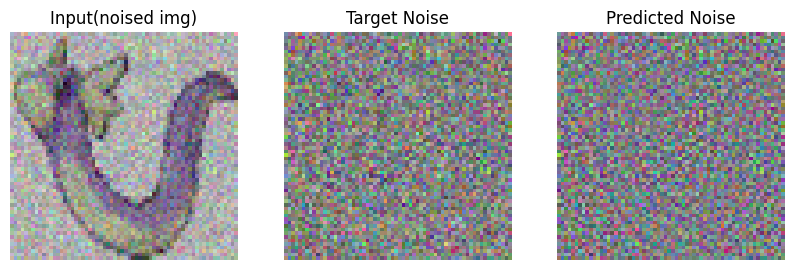

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.034082517, shape=(), dtype=float32)
MSE:  tf.Tensor(0.5602224, shape=(), dtype=float32)


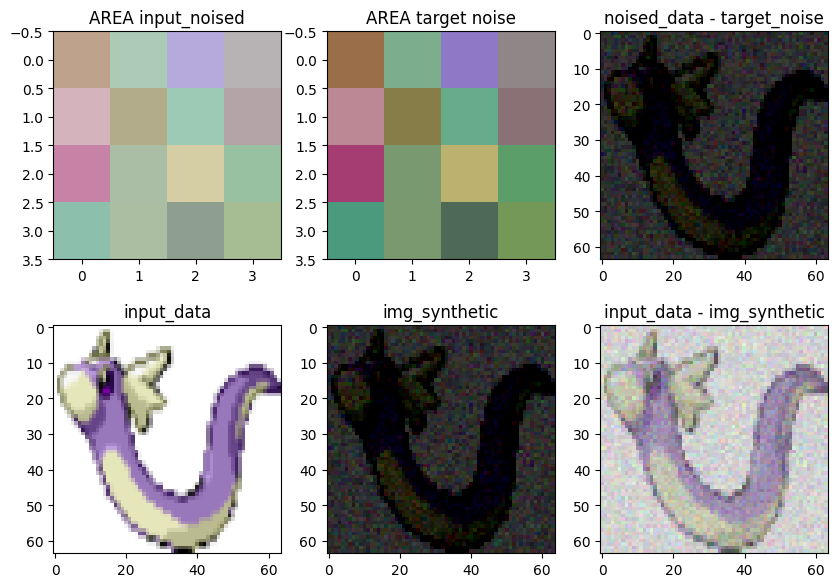

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - loss: 0.0959
Epoch 77/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.0688
Epoch 78/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 0.0521
Epoch 79/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - loss: 0.1013
Epoch 80/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0558

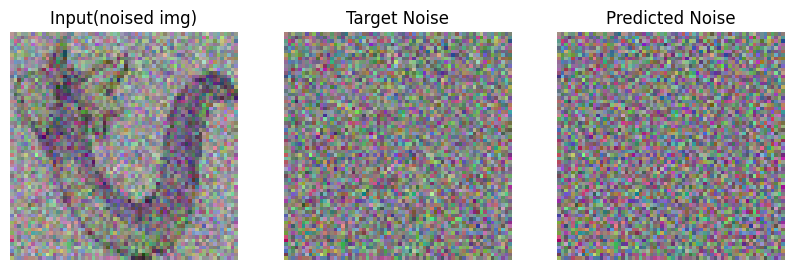

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.008114564, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6695053, shape=(), dtype=float32)


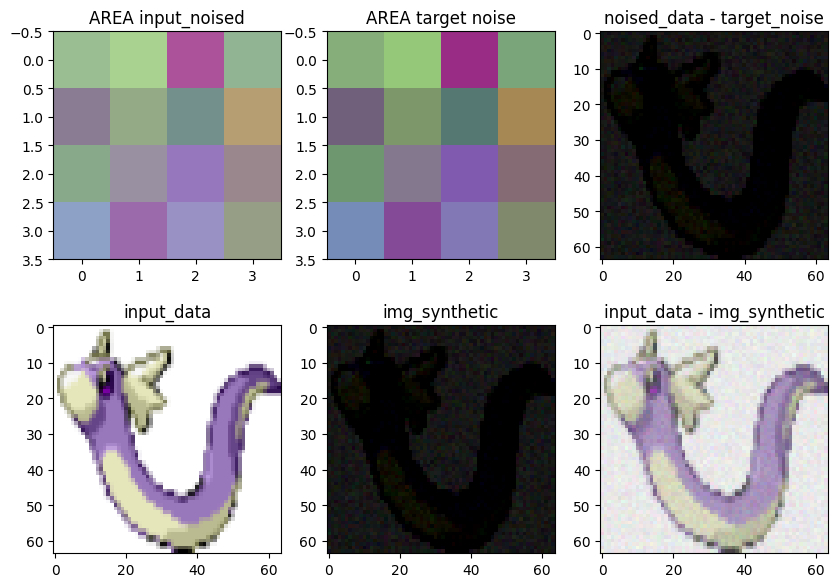

Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:21<00:00, 23.06it/s]


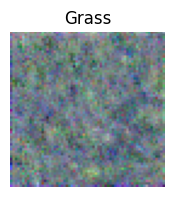

8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - loss: 0.0496  
Epoch 81/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.0473
Epoch 82/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.0780
Epoch 83/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.1101
Epoch 84/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0690

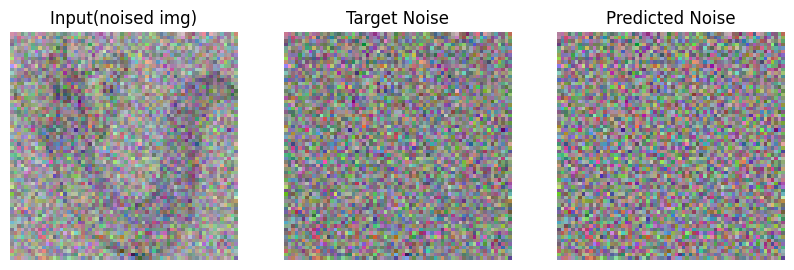

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.007942873, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6403146, shape=(), dtype=float32)


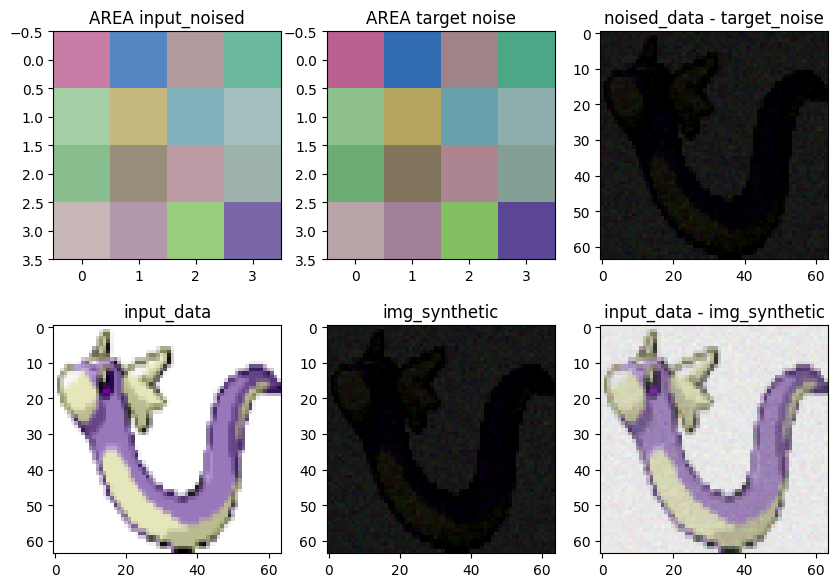

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - loss: 0.0614
Epoch 85/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1567
Epoch 86/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1268
Epoch 87/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.1292
Epoch 88/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.0690

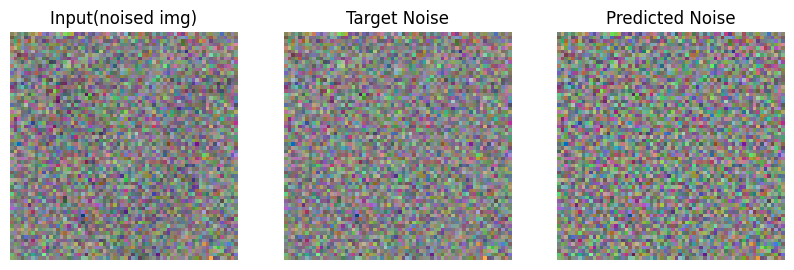

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(5.366078e-16, shape=(), dtype=float32)
MSE:  tf.Tensor(0.75948304, shape=(), dtype=float32)


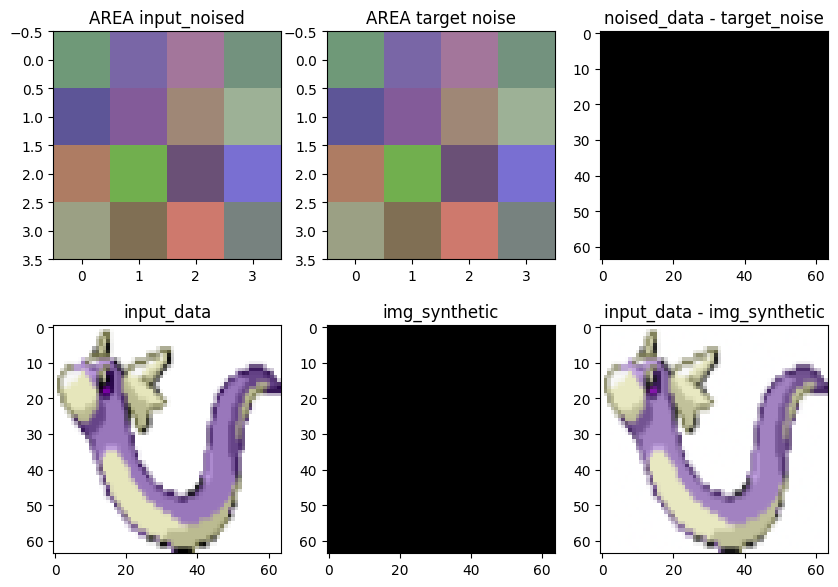

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step - loss: 0.0613
Epoch 89/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1320
Epoch 90/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.0749
Epoch 91/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.0568
Epoch 92/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0720

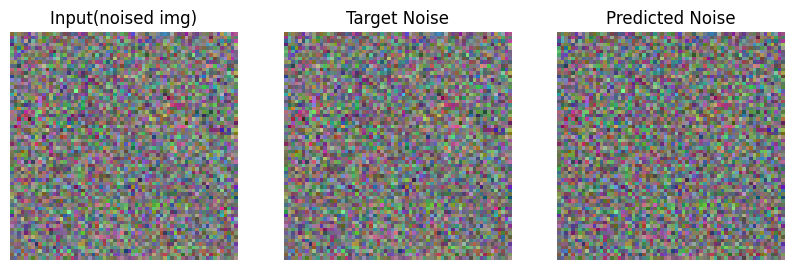

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(5.6029374e-05, shape=(), dtype=float32)
MSE:  tf.Tensor(0.73492575, shape=(), dtype=float32)


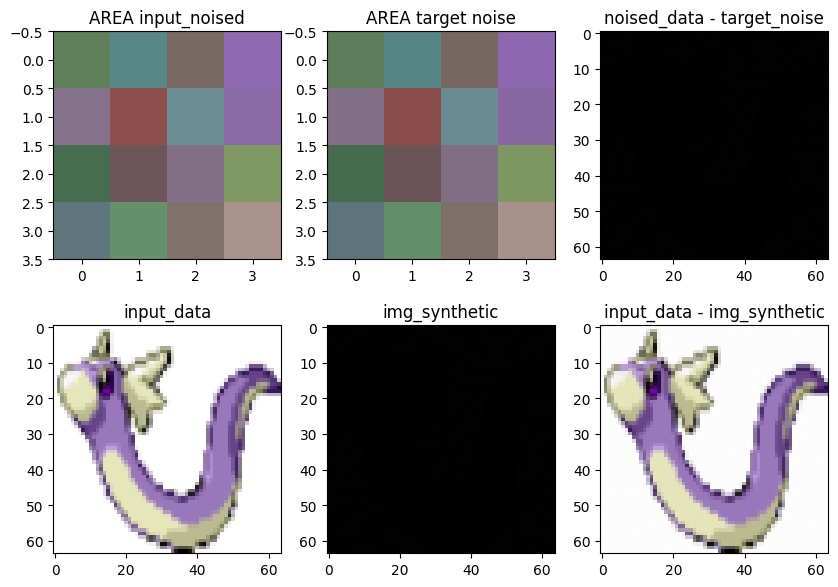

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - loss: 0.0640
Epoch 93/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.0389
Epoch 94/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - loss: 0.1080
Epoch 95/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.1109
Epoch 96/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.0526

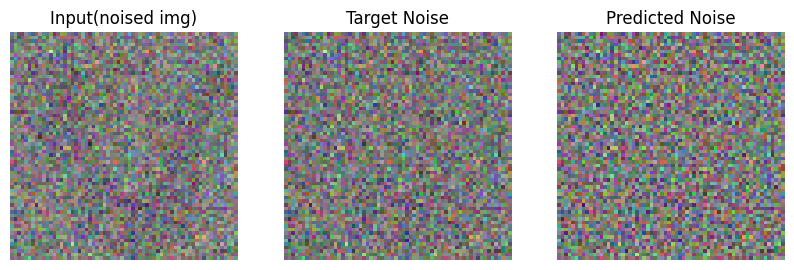

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0007397765, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7191507, shape=(), dtype=float32)


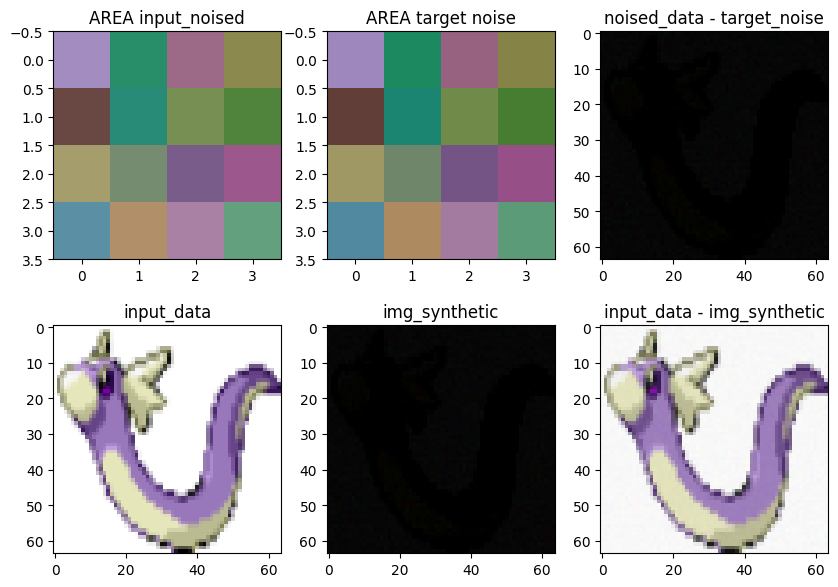

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - loss: 0.0467
Epoch 97/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.0418
Epoch 98/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.1329
Epoch 99/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.0995
Epoch 100/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.0857

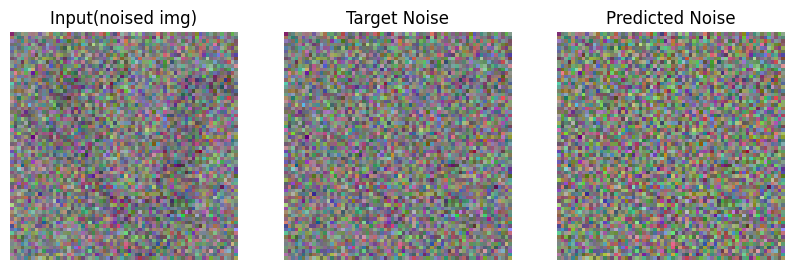

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.00028132065, shape=(), dtype=float32)
MSE:  tf.Tensor(0.73555905, shape=(), dtype=float32)


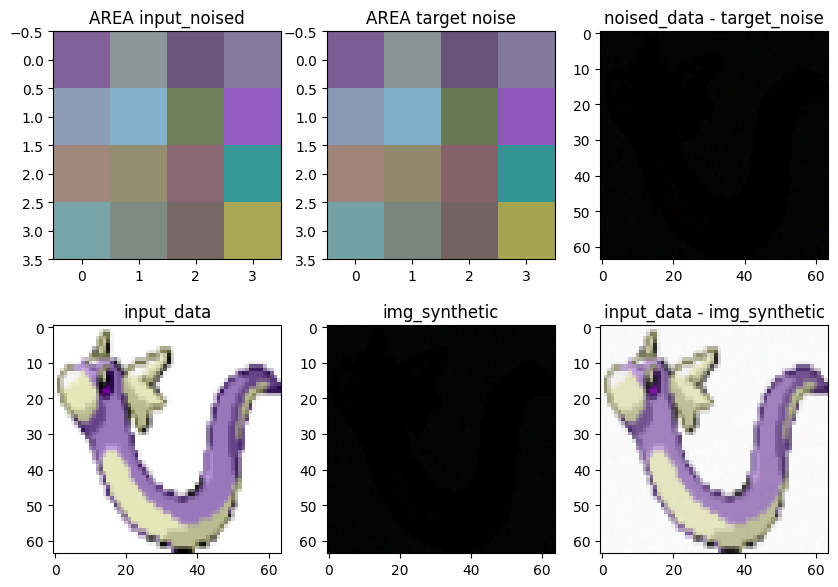

Epoch 100: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:22<00:00, 21.72it/s]


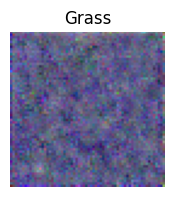

8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - loss: 0.0762  


In [39]:
tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(
    dataset_example,
    epochs=EPOCHS,
    callbacks=[PlottingCallback(model, 4), DiffusionCallback(model, 20)],
)
# model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 10)])

Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:22<00:00, 22.27it/s]


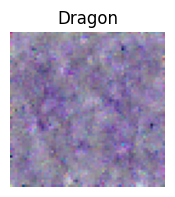

In [40]:
model.plot_samples(1, "Dragon")

Generating sample 1/4


Sampling sprite: 100%|██████████| 499/499 [00:20<00:00, 24.41it/s]


Generating sample 2/4


Sampling sprite: 100%|██████████| 499/499 [00:20<00:00, 24.46it/s]


Generating sample 3/4


Sampling sprite: 100%|██████████| 499/499 [00:20<00:00, 24.37it/s]


Generating sample 4/4


Sampling sprite: 100%|██████████| 499/499 [00:20<00:00, 24.70it/s]


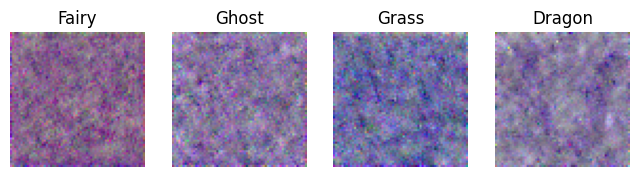

In [41]:
model.plot_samples(4)

In [ ]:
# df = preprocess.load_csv("../../dataset/pokedex.csv")
# data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
# data_dict = preprocess.dataset_dict(data_path, df)
# dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
# label_mappping = preprocess.create_label_mapping(df)

# def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
#     """Generates a random embedding (label)

#     :param num_classes: The number of classes
#     """

#     em = np.zeros(num_classes)
#     em[np.where(label_example[0] == 1)[0][0]] = 1
#     return em


# generate_em()
# plotter.onehot_to_string(generate_em(), label_mappping)